# State preparation example

In this example we will use the generator to find quantum circuit which prepares the state with probability distribution given as input. We compared with Qiskit's "isometry" method, which works much faster but outputs much deeper circuit with a lot of CNOTs.

## Prerequisites:

Install Quantastica QPS API by uncommenting this line:

In [1]:
# !pip install quantastica-qps-api

Fore details see: https://pypi.org/project/quantastica-qps-api/

**You need to run following only once on this system** and then remove the cell - don't keep your API key in notebook.

Uncomment following two lines, add your API key and run:

In [2]:
# from quantastica.qps_api import QPS

# QPS.save_account("YOUR_API_TOKEN")

## First, we will create target probability distribution

Can be output of any function which returns list of real numbers

Input probability distribution


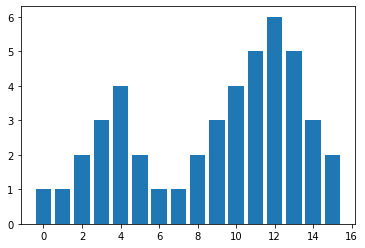

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from quantastica.qps_api import QPS
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer

import scipy.interpolate as interpolate
import numpy as np

#
# Function converts probability distribution to state vector
# Given vector (of any size and any value range) will be normalized and interpolated to 2**num_qubits
#
def pd_to_sv(pd, num_qubits):
    len_sv = 2**num_qubits

    # get rid of negative values
    min_val = np.min(pd)
    if(min_val < 0):
        pd = [i + np.abs(min_val) for i in pd]
    
    # interpolate to 2**num_qubits if needed
    if(len_sv != len(pd)):
        x = np.arange(0, len(pd))
        f = interpolate.interp1d(x, pd)
        xnew = np.linspace(0, len(pd) - 1, num = int(len_sv))
        pd = f(xnew)

    # normalize sum to 1
    pd = pd / np.sum(pd)
    
    # Make statevector
    pd = np.sqrt(pd).tolist()
    
    # convert to complex
    sv = [complex(i) for i in pd]

    return sv


# Input probability distribution (can be any function which returns list of real numbers)
input_dist = [1, 1, 2, 3, 4, 2, 1, 1, 2, 3, 4, 5, 6, 5, 3, 2]

num_qubits = 4

target_state = pd_to_sv(input_dist, num_qubits)


# Plot input probability distribution

print("Input probability distribution")
plt.bar(np.arange(0, len(input_dist)), input_dist)
plt.show()



## Using Qiskit to prepare state

Qiskit isometry + transpile:


Depth: 23
Ops: 26
CNOTs: 11


/usr/local/lib/python3.8/dist-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


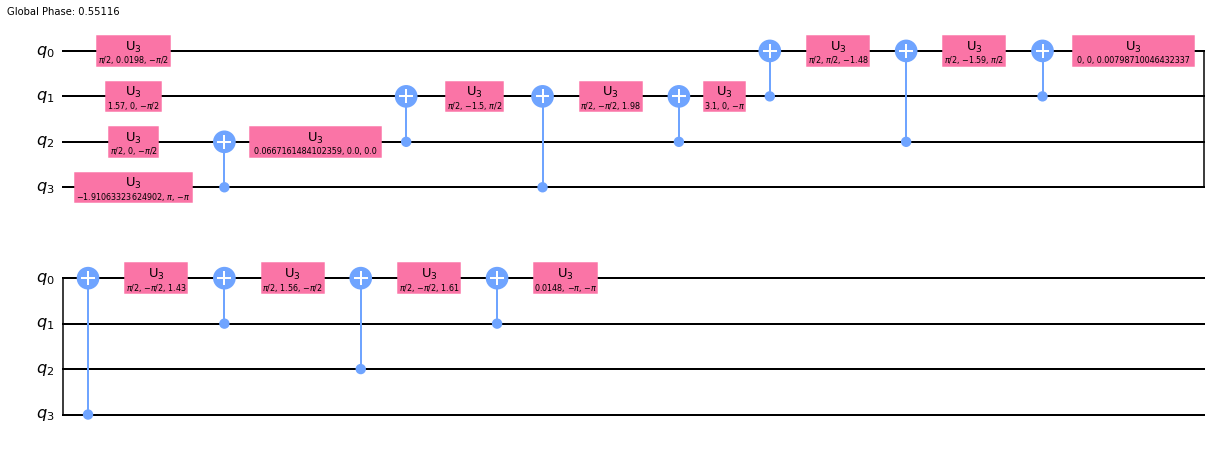

Output probability distribution


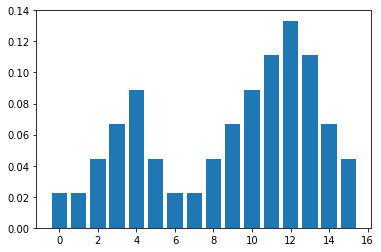

In [4]:
from qiskit.compiler import transpile

print("Qiskit isometry + transpile:")
print("")


# Use qiskit to prepare state
qc = QuantumCircuit()
qreg = QuantumRegister(num_qubits, "q")
qc.add_register(qreg)    
qc.isometry(target_state, qreg[:num_qubits], [])
qc = transpile(qc, basis_gates=["id", "u3", "cx"], optimization_level=3)

print("")
print("Depth:", qc.depth())
print("Ops:", sum(j for i, j in qc.count_ops().items()))
print("CNOTs:", qc.count_ops()["cx"] if "cx" in qc.count_ops() else 0)

display(qc.draw(output="mpl"))

# Run circuit on state vector simulator
backend = Aer.get_backend("statevector_simulator")
job = execute(qc, backend=backend)
job_result = job.result()

# Read state vector and convert it to pd
output_vector = job_result.get_statevector(qc)
output_dist = np.abs(output_vector)**2

# Plot output pd
print("Output probability distribution")
plt.bar(np.arange(0, len(output_dist)), output_dist)
plt.show()



## Quantastica generator

Quantastica generator:


Depth: 9
Ops: 19
CNOTs: 5


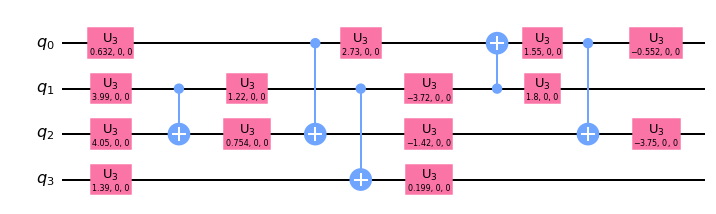

Output probability distribution


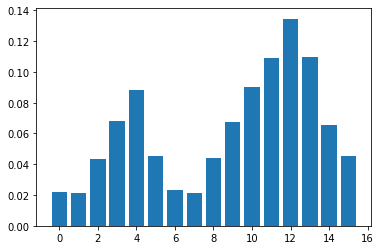

In [5]:
print("Quantastica generator:")
print("")


job_id = QPS.generator.state_preparation(target_state, settings = { "instruction_set": ["u3", "cx"], "max_diff": 0.001, "pre_processing": "experimental5" })
job = QPS.generator.get_job(job_id, wait=True)
job_status = job["status"]
job_output = job["output"]

if(job_status == "error"):
    raise Exception(job_output["message"])
else:
    if "circuits" not in job_output or len(job_output["circuits"]) == 0:
        raise Exception("No solutions")

qasm = job_output["circuits"][0]["qasm"]


# To visualize result, we will make Qiskit circuit from returned QASM
qc = QuantumCircuit.from_qasm_str(qasm)

print("")
print("Depth:", qc.depth())
print("Ops:", sum(j for i, j in qc.count_ops().items()))
print("CNOTs:", qc.count_ops()["cx"] if "cx" in qc.count_ops() else 0)

display(qc.draw(output="mpl"))

# Run circuit on state vector simulator
backend = Aer.get_backend("statevector_simulator")
job = execute(qc, backend=backend)
job_result = job.result()

# Read state vector and convert it to pd
output_vector = job_result.get_statevector(qc)
output_dist = np.abs(output_vector)**2

# Plot output pd
print("Output probability distribution")
plt.bar(np.arange(0, len(output_dist)), output_dist)
plt.show()

